Dans le secteur de la santé à domicile, les infirmiers et les médecins effectuent des tournées pour visiter plusieurs patients à leur domicile. L'optimisation de ces tournées est essentielle pour :

* Réduire le temps de trajet, permettant de voir plus de patients en moins de temps.
* Minimiser les coûts (essence, usure du véhicule, frais de déplacement).
* Améliorer la qualité des soins en réduisant la fatigue des soignants et en garantissant la ponctualité.

Cette problématique peut être directement modélisée comme un **Problème du Voyageur de Commerce (PVC)**, en anglais the **Traveling Salesman Problem (TSP)**. Ce problème est bien connu dans la littérature, il peut être exprimé comme suit :

# Étant donné une liste de points et les distances entre chaque paire de points, quel est l'itinéraire le plus court possible pour visiter chaque point et revenir au point de départ ?

Ce problème possède plusieurs variantes et applications. Dans le domaine de la santé, outre l'optimisation des ressources pour l'HAD (Hospitalisation à Domicile) – https://hal.science/hal-01044652, il trouve également des applications intéressantes en bioinformatique, notamment dans la construction de cartes génétiques (gene mapping).

L’objectif du gene mapping est de déterminer l’emplacement des gènes sur les chromosomes et d’identifier leurs relations avec des traits spécifiques ou des maladies. Les gènes peuvent être représentés comme des "points" sur un chromosome, et les distances entre eux sont mesurées en nombre de paires de bases, une unité correspondant à la longueur d'une séquence d'ADN :

* https://www.sciencedirect.com/science/article/pii/S2214514120300519
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6816573
* https://miat.inrae.fr/degivry/Givry03c.pdff



Dans le cadre de ce TD, nous nous intéressons à la version originale de ce problème d'optimisation. Plusieurs méthodes sont possibles pour sa résolution. Nous utiliserons l'Algorithmes Génétique (AG) qui fait partie des méthodes approchées de résolution permettant une exploration parallèle dans l'espace de recherche.

**<span style="color:red">
NOTE IMPORTANTE
</span>**

Nous nous intéresserons plus particulièrement à l'optimisation collaborative : un SMA d'agents optimisateurs qui, en collaborant, essaient de converger le plus rapidement possible vers la solution optimale. Notre objectif est donc de comparer le travail d'un AG unique contre un SMA collaboratif avec des agents ayant des comportements optimisateurs. Nous commencerons avec des comportements optimisateurs basés uniquement sur les AGs. Vous pouvez par la suite tester la collaboration de plusieurs agents ayant des comportements optimisateurs différents.

# Partie 1 : Point, Liste de points et itinéraires

1. Créez la classe _Point_  :
* Avec un constructeur permettant de créer un point avec ses coordonnées x et y correspondant à l'abscisse et l'ordonnée d'une case dans un plan cartésien.
* Redéfinissez la fonction native _**repr**_ pour afficher proprement les coordonnées d'un point sous forme (x,y).
* Testez cette classe en créant quelques points et en les affichant

**<span style="color:red">
SOLUTION
</span>**

In [1]:
class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def repr(self):
        return f"{(self.x,self.y)}"


p1 = Point(2,3)
p2 = Point(2,5)
print(p1.repr())
print(p2.repr())



(2, 3)
(2, 5)


2. Ajoutez à la classe _**Point**_ la fonction **_distance_** (qu'il faut tester) permettant de retourner la distance entre le point actuel et un autre point en paramètre. Utilisez le théorème de Pythagore pour calculer la distance orthogonale entre 2 points p et q de coordonnées (p1,p2) et (q1,q2) comme le montre la figure ci-dessous :

![Pythagore](https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Euclidean_distance_2d.svg/1920px-Euclidean_distance_2d.svg.png)

**<span style="color:red">
SOLUTION
</span>**

In [2]:
class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"{(self.x,self.y)}"

    def dist(self,p):
        x = self.x
        y = self.y
        px = p.x
        py = p.y
        return ( (x-px)**2 + (y-py)**2  )**(1/2)

p1 = Point(2,3)
p2 = Point(2,5)
print(p1)
print(p1.dist(p2))


(2, 3)
2.0


3. Dans un programme principal :
* Créez :
    * une variable N : initialisée au nombre de points à visiter.
    * les variables L et H : initialisées à la longueur et la hauteur de la grille où sont placés vos points.
    * une liste vide appelée **pointsL** qui va contenir vos N points de type Point.
* Alimentez cette liste avec vos N points avec des coordonnées x et y générés aléatoirement avec x<=L et y<=H.
* Affichez le contenu de cette liste.

**<span style="color:red">
SOLUTION
</span>**

In [3]:
import random as rd
N = 10
L = 10
H = 10
pointsL = []
for _ in range(N):
    x = rd.randint(0,L)
    y = rd.randint(0,H)
    point = Point(x,y)
    pointsL.append(point)
print(pointsL)

[(1, 3), (8, 8), (7, 7), (4, 7), (10, 2), (1, 0), (4, 7), (6, 9), (4, 1), (5, 1)]


4. Créez une fonction indépendante _**createIt**_ qui permet, à partir d'une liste de points (de type Point), de générer une nouvelle liste composée des mêmes éléments de la liste de départ mais avec un ordre complètement aléatoire. L'objectif est de générer des itinéraires complétement aléatoires entre les différents points d'une même liste de points.
\
Pensez à la fonction _**sample**_ de la bibliothèque _**random**_ (voir API Python). Testez-la avec la liste **pointsL** que vous avez créée précédemment en générant quelques itinéraires aléatoires à partir de cette même liste. Affichez ces itinéraires issus de la même liste de points **pointsL**.

**<span style="color:red">
SOLUTION
</span>**

In [4]:
def createlt(L_points):
    return rd.sample(L_points,len(L_points))
print(pointsL)

[(1, 3), (8, 8), (7, 7), (4, 7), (10, 2), (1, 0), (4, 7), (6, 9), (4, 1), (5, 1)]


# Partie 2 : L'Algorithme génétique (AG)

Un AG cherche à converger vers la solution optimale (pour notre PVC : l’itinéraire avec la distance à parcourir la plus faible) grâce à une recherche parallèle avec une population de solutions. Donc, pour notre PVC, à partir d'une population initiale d'itinéraires, un AG va générer une nouvelle population d'itinéraires qui va évoluer au fur et à mesure des générations comme le montre la figure ci-dessous.

![AG](https://upload.wikimedia.org/wikipedia/commons/4/42/Schema_simple_algorithme_genetique.png)

## Chromosome et gène

Une solution d'un algorithme génétique s'appelle un chromosome et un gène en est une partie. Un chromosome d'un AG peut avoir n'importe quelle forme (liste, matrice...). Cette dernière doit être pertinente pour votre algorithme et la résolution du problème cible.

Dans le cadre de ce TD, un chromosome correspond à un itinéraire possible sous forme d'une liste de points. L'ordre des points d'un itinéraire correspond à l'ordre de passage sur ces points en retournant à la fin au point de départ qui correspond au 1er élément de la liste.

Un AG est caractérisé, entre autres, par la taille de sa population (le nombre de chromosomes). Il démarre avec une population initiale pouvant être générée aléatoirement.

## Population initiale

5. Créez la fonction indépendante __**initialPopulation**__ qui, à partir d'une taille de population __**popSize**__ et d'une liste de points _**pointsL**_, cette fonction retourne une population de chromosomes (en utilisant la fonction _**createIt**_ créée précédemment). Testez-la en créant et affichant quelques populations. Par exemple :  _**myPop1**_ de taille 10 ou _**myPop2**_ de taille 7.

**<span style="color:red">
SOLUTION
</span>**

In [5]:
def initialPopulation(popSize,pointsL):
    res = []
    while (len(res) < len(pointsL)):
        L = createlt(pointsL)
        if L not in res:
            res.append(L)
    return res
myPop1 = initialPopulation(10,pointsL)
myPop2 = initialPopulation(7,pointsL)
print(myPop1 )
print(myPop2)


[[(4, 7), (1, 3), (6, 9), (10, 2), (8, 8), (4, 1), (4, 7), (5, 1), (7, 7), (1, 0)], [(10, 2), (8, 8), (7, 7), (4, 1), (4, 7), (4, 7), (1, 0), (1, 3), (6, 9), (5, 1)], [(10, 2), (8, 8), (4, 1), (4, 7), (4, 7), (5, 1), (1, 3), (7, 7), (6, 9), (1, 0)], [(7, 7), (10, 2), (5, 1), (4, 7), (8, 8), (1, 0), (4, 1), (4, 7), (1, 3), (6, 9)], [(7, 7), (5, 1), (4, 7), (4, 7), (1, 3), (1, 0), (8, 8), (6, 9), (4, 1), (10, 2)], [(10, 2), (6, 9), (4, 7), (4, 1), (7, 7), (5, 1), (1, 0), (1, 3), (4, 7), (8, 8)], [(5, 1), (4, 7), (1, 3), (4, 7), (4, 1), (8, 8), (7, 7), (1, 0), (6, 9), (10, 2)], [(6, 9), (1, 0), (7, 7), (10, 2), (4, 7), (4, 1), (1, 3), (4, 7), (5, 1), (8, 8)], [(7, 7), (6, 9), (10, 2), (8, 8), (1, 3), (5, 1), (4, 1), (4, 7), (1, 0), (4, 7)], [(10, 2), (4, 7), (8, 8), (4, 1), (1, 3), (5, 1), (6, 9), (1, 0), (7, 7), (4, 7)]]
[[(8, 8), (1, 0), (10, 2), (4, 1), (5, 1), (1, 3), (7, 7), (6, 9), (4, 7), (4, 7)], [(7, 7), (4, 7), (4, 7), (4, 1), (5, 1), (1, 0), (8, 8), (6, 9), (1, 3), (10, 2)], [(

## La fonction Objectif (FO) - Fitness - Critère

L'objectif est de minimiser la distance totale en trouvant le meilleur ordre permettant de parcourir tous les points de la liste et en retournant au point de départ avec la distance la plus faible possible.


Il est recommandé de normaliser la fonction fitness d'un algorithme génétique pour qu'elle soit dans la plage de 0 à 1. La normalisation est une étape importante pour s'assurer que les valeurs de fitness restent cohérentes et comparables entre différentes exécutions de l'algorithme, ainsi qu'entre différentes populations et problèmes.

Plusieurs méthodes sont possibles, nous choisissons un fitness normalisé correspondant à l'inverse du fitness brut (la distance totale): Minimiser la distance totale revient donc à maximiser son inverse qui sera ainsi compris entre 0 et 1. La FO ou fonction objectif (fitness) à maximiser est donc l'inverse de la distance totale à minimiser. Il s'agit de l'itinéraire partant d'un point, parcourant tous les autres points de la liste dans l'ordre des indices et retournant au point de départ.

6. Créez la classe Fitness avec:
* Le constructeur :  qui crée une instance avec un itinéraire (une variable _**it**_ en paramètre qui correspond à l'itinéraire des points à visiter). Ce constructuer initialise la variable distance à 0 et la variable fitness à 0.0 (correspondant à la valeur de la FO).
* La fonction _**itDistance**_ : qui retourne la distance totale de l’itinéraire de la classe. Il s'agit de la distance lotale à parcourir en passant par tous les points dans l'ordre. N'oubliez pas de rajouter la distance permettant de retourner au point de départ correspondant au 1er élément de la liste.
* La fonction _**itFitnes**_ : qui retourne la valeur de fitness FO (si ce n'est pas encore fait) càd le critère à maximiser. Il s'agit tout simplement de l'inverse de _**itDistance**_ puisque plus la distance est faible, plus la FO est importante.

**<span style="color:red">
SOLUTION
</span>**

In [6]:
class Fitness:
    def __init__(self,it):
        self.it = it
        self.distance = 0
        self.fitness = 0.0

    def itDistance(self):
        it = self.it
        for k in range(len(it)-1):
            depart = it[k]
            fin = it[k+1]
            self.distance += depart.dist(fin)
        premier = it[0]
        dernier = it[-1]
        self.distance += premier.dist(dernier)
        return self.distance

    def itFitness(self):
        return 1/(self.itDistance())

fit = Fitness(pointsL)
print(fit.itFitness())




0.018447162026426146


7. Calculez et affichez la distance ainsi que la valeur de fitness d'un itinéraire créé précédemment (question n°4).

**<span style="color:red">
SOLUTION
</span>**

In [7]:
fit = Fitness(pointsL)
print(fit.itFitness())

0.018447162026426146


8. Affichez les valeurs de fitness de tous les chromosomes d'une population créée précédemment (question n° 5).

**<span style="color:red">
SOLUTION
</span>**

In [8]:
popSize = 10
L_chromosomes = initialPopulation(popSize,pointsL)
for chromosome in L_chromosomes:
    fit = Fitness(chromosome)
    print(fit.itFitness())


0.017416930302666264
0.016216191342145327
0.01703779878756012
0.018670706641592063
0.016206936752453733
0.015766953979699124
0.021319319474995123
0.015994799455831498
0.015694502653333286
0.017818816276890914


9. Maintenant, nous allons créer une fonction rankIts(population) qui renvoie une liste triée de tuples (iDIt, fitness) d'une population d'itinéraires (une liste d'itinéraires) selon la valeur de fitness décroissante.
\
iDIt est l'index de l'itinéraire dans la population (le 1er d'indice 0, le 2ème d'indice 1 etc.).
\
Une solution possible est de créer un dictionnaire (clé->id et valeur->fitness), la fonction _**item**_ d'un dictionnaire renvoie la liste de tuples (clé, valeur). Nous pouvons utiliser la fonction **sorted** de Python comme suit :
**sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)**
avec :
* fitnessResults : votre dictionnaire avec comme clés : les iD des itinéraires et comme valeurs : les fitness
* key = operator.itemgetter(1) : correspond au critère de tri, il s'agit ici des éléments d'indice 1 du tuple (clé, valeur) et donc ça correspond à la valeur du fitness. N'oublions pas d'importer le module _**operator**_

**<span style="color:red">
La fonction rankIts(population)
</span>**

In [9]:
import operator
def rankIts(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).itFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

popRanked=rankIts(myPop2)
print(popRanked)
print(popRanked[0][1])

[(0, 0.020919061375235526), (1, 0.020126431779052177), (8, 0.019508433958386296), (4, 0.018729515365244327), (3, 0.01798554107187277), (6, 0.017617687106875182), (2, 0.016698015028708053), (9, 0.0165482147695151), (7, 0.01653164500114834), (5, 0.016185726612886284)]
0.020919061375235526


## Sélection des parents de la prochaine génération
Plusieurs techniques sont possibles (vous pouvez créer la vôtre), ci-dessous 2 techniques connues :
* “roulette wheel selection” (sélection proportionnelle à la valeur du fitness) : la sélection d'un individu est proportionnelle à sa valeur de fitness, la probabilité de sélection est pondérée par la valeur de fitness
* l'élitisme : les individus les plus performants de la population sont automatiquement transférés à la génération suivante, ce qui garantit la persistance des individus leluss p fo.. :


Dans la littérature, des études scientifiques ont démontré que l'élitisme n'est pas forcément le meilleur mode de sélection et que le fait de donner la chance à certains individus "faibles" permet de diversifier la population pour la rendre encore plus forte.
Nous choisissons ici de combiner les 2 techniques présentées ci-dessus :

10. Créez d'abord une DataFrame pandas ayant comme données le résultat de la fonction **rankIts(population)** sous forme d'une matrice numpy en intitulant les 2 colonnes par ordre :"Index" et "Fitness"

**<span style="color:red">
SOLUTION
</span>**

In [10]:
import pandas as pd
pop=rankIts(myPop1)
df = pd.DataFrame([(pop[k][0], pop[k][1]) for k in range(len(pop))], columns=["Index", "Fitness"])
df.head()

,Index,Fitness
0,1,0.019218
1,5,0.019050
2,4,0.018715
3,8,0.018205
4,3,0.017865


11. Ajoutez à cette DataFrame une colonne 'cum_sum' permettant de calculer la somme cumulative de la colonne 'Fitness' (voir la fonction cumsum() de Series).

**<span style="color:red">
SOLUTION
</span>**

In [11]:
df["cum_sum"] = df["Fitness"].cumsum()
df.head()

,Index,Fitness,cum_sum
0,1,0.019218,0.019218
1,5,0.019050,0.038268
2,4,0.018715,0.056983
3,8,0.018205,0.075188
4,3,0.017865,0.093053


12. Ajoutez à cette même DataFrame une colonne 'cum_perc' corresppondant au pourcentage cumulatif de la valeur de fitness, calculé comme suit : cum_sum*100/somme(Fitness):

**<span style="color:red">
SOLUTION
</span>**

In [12]:
df["cum_perc"] = df["cum_sum"]*100/(df["Fitness"]).sum()
df.head(10)

,Index,Fitness,cum_sum,cum_perc
0,1,0.019218,0.019218,11.288551
1,5,0.019050,0.038268,22.478195
2,4,0.018715,0.056983,33.471149
3,8,0.018205,0.075188,44.164821
4,3,0.017865,0.093053,54.658719
5,2,0.016693,0.109747,64.464258
6,7,0.015699,0.125446,73.685977
7,6,0.015568,0.141014,82.830295
8,9,0.015046,0.156060,91.668436
9,0,0.014184,0.170244,100.000000


In [13]:
def to_df(PopRanked):
    df = pd.DataFrame([(PopRanked[k][0], PopRanked[k][1]) for k in range(len(PopRanked))], columns=["Index", "Fitness"])
    df["cum_sum"] = df["Fitness"].cumsum()
    df["cum_perc"] = df["cum_sum"]*100/(df["Fitness"]).sum()
    return df
df = to_df(popRanked)
df.head()

,Index,Fitness,cum_sum,cum_perc
0,0,0.020919,0.020919,11.567061
1,1,0.020126,0.041045,22.695843
2,8,0.019508,0.060554,33.482906
3,4,0.018730,0.079283,43.839272
4,3,0.017986,0.097269,53.784262


13. Créez la liste **selectionResults** qui contient les index des des n premiers individus (les n meilleurs) de **popRanked** . Testez avec un n < taille de **popRanked**

**<span style="color:red">
SOLUTION
</span>**

In [14]:
def selection_res(n,popRanked):
    res = []
    for k in range(n):
        res.append(popRanked[k][0])
    return res
selectionResults = selection_res(4,popRanked)
print(selectionResults)



[0, 1, 8, 4]


14. Nous allons maintenant compléter la liste **selectionResults** de 0 jusqu'à **popRanked** - n de la manière suivante :
* Pour chaque i de 0 jusqu'à (**taille(popRanked)** - n) :
    * tirer au hasard une valeur entre 0 et 100
    * répéter j de 0 à len(popRanked) :
        * Si la valeur tirée au hasard <= à la ième (à partir de 0) valeur cumulative cum_perc de la dataFrame créée précédemment ALORS le ième index dans **popRanked** est rajouté à **selectionResults** SINON passer au tour suivant (j+1)

**<span style="color:red">
Finalisons l'étape de sélection
</span>**

In [15]:
df = to_df(popRanked)
for i in range(len(popRanked) - 4):
    pick = rd.randint(0,100)
    for j in range(len(popRanked)):
        if pick <= df["cum_perc"].iloc[j]:
            selectionResults.append(popRanked[j][0])
            break
selectionResults

[0, 1, 8, 4, 0, 5, 6, 3, 1, 0]

15. Créez et testez la fonction **selection(popRanked, eliteSize)** qui retourne la liste des index des individus pour la suite du processus : la phase de reproduction. Cette fonction permet de regrouper les actions des questions de 10 à 14 avec :
* eliteSize : le nombre fixé des meilleurs éléments (les individus ayant les meilleurs valeurs de fitness).
* popRanked : liste triée de tuples (iDIt, fitness) d'une population d'itinéraires (une liste d'itinéraires) selon la valeur fitness décroissante.


**<span style="color:red">
SOLUTION
</span>**

In [16]:
import numpy as np
import random
import pandas as pnd
def selection(popRanked, eliteSize):
    # Crée une liste vide qui contiendra les résultats de la sélection
    selectionResults = []

    # Crée un DataFrame à partir de la population triée (popRanked) avec les colonnes "Index" et "Fitness"
    df = pnd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])

    # Calcule la somme cumulée des fitness, ce qui est utilisé pour la roulette
    df['cum_sum'] = df.Fitness.cumsum()

    # Calcule le pourcentage cumulatif, ce qui permet de déterminer la probabilité de chaque individu d'être sélectionné
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    # Sélectionne les individus les mieux classés (élite) en les ajoutant directement à la liste de sélection
    for i in range(eliteSize):
        selectionResults.append(popRanked[i][0])

    # Sélectionne les autres individus de manière aléatoire, pondérée par leur fitness
    for i in range(len(popRanked) - eliteSize):
        pick = 100*random.random()  # Tirage aléatoire pour choisir un individu
        for i in range(len(popRanked)):  # Parcours de la population
            # Si la valeur tirée est inférieure ou égale au pourcentage cumulé de l'individu, on le sélectionne
            if pick <= df.iat[i,3]:  # La colonne 3 contient les pourcentages cumulés
                selectionResults.append(popRanked[i][0])  # Ajoute l'individu sélectionné
                break  # Sort de la boucle dès que l'individu est sélectionné

    return selectionResults  # Retourne la liste des individus sélectionnés
print(selection(popRanked, 2))

[0, 1, 2, 6, 8, 3, 2, 1, 6, 7]


16. L'étape précédente a permis de générer la liste des index des individus sélectionnés pour la phase de reproduction. Il faut créer maintenant la liste de ces individus avec la nouvelle fonction **matingPool(population, selectionResults)** qu'il faut tester avec :
* population : votre population d'itinéraires de départ
* selectionResults : la liste des index des individues sélectionnés pour la reproducti.1.


**<span style="color:red">
SOLUTION
</span>**

In [17]:
def matingPool(population, selectionResults):
    # Crée une liste vide qui contiendra les individus sélectionnés pour la reproduction
    matingpool = []

    # Parcours les indices des individus sélectionnés
    for i in range(len(selectionResults)):
        # Récupère l'indice de l'individu sélectionné dans la liste 'selectionResults'
        index = selectionResults[i]

        # Ajoute l'individu correspondant à cet indice dans la liste 'matingpool'
        matingpool.append(population[index])

    # Retourne la liste des individus sélectionnés pour la reproduction
    return matingpool


## Croisement et mutation
A l'instar de la génétique humaine, les chromosomes parents passent par une étape de croisement pour donner les chromosomes enfants. Ces derniers peuvent muter.
Un algorithme génétique est généralement paramétré avec une probabilité de croisement et une probabilité de mutation.

### Croisement

Plusieurs types d'opérateurs de croisement existent dans la littérature (vous pouvez créer le votre). Nous choisissons dans le cadre de ce TD l'opérateur de croisement à 2 points.

![Croisement](https://i0.wp.com/ledatascientist.com/wp-content/uploads/2020/10/Two-point-XO.png?resize=1024%2C279&ssl=1)

Le schéma ci-dessus montre un opérateur de croisement à 2 points classique. Dans le cadre du PVC, nous devons adapter ce croisement de manière à ce que toutes les villes soient dans la liste une seule et unique fois.

Pour respecter cette règle, nous pouvons utiliser une fonction de croisement spéciale appelée croisement ordonné (exemple figure ci-dessous). Dans le croisement ordonné choisi, l'enfant hérite d'abord un ensemble de gènes successifs du premier parent en bleu (gènes successifs choisis au hasard en jaune), puis le reste de l'itinéraire enfant est rempli avec les gènes du deuxième parent en rose dans l'ordre dans lesquels ils apparaissent en ignorant ceux qui y existent déjà.

![Capture d’écran 2024-02-02 à 22.02.00.png](attachment:488a20b9-ba3c-4a1e-8fdd-bc19750eb089.png)

17. Créez la fonction croisementOr(parent1, parent2) et testez sur la sur 2 itinéraires créés précédemment (question n°4).

**<span style="color:red">
SOLUTION
</span>**

In [18]:
def croisementOr(parent1, parent2):
    # Initialisation des listes vides pour les enfants
    child = []
    childP1 = []
    childP2 = []

    # Choix aléatoire de deux indices entre 0 et la taille de parent1
    geneA = random.randint(0, len(parent1))  # Premier indice de croisement
    geneB = random.randint(0, len(parent1))  # Deuxième indice de croisement

    # Définir les indices de début et de fin du croisement en prenant le min et max des deux indices choisis
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    # Copie de la portion du parent1 entre les indices choisis dans childP1
    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    # Ajouter les éléments du parent2 qui ne sont pas déjà dans childP1 à childP2
    childP2 = [item for item in parent2 if item not in childP1]

    # Le nouvel enfant est la concaténation de childP1 (portion de parent1) et de childP2 (éléments restants de parent2)
    child = childP1 + childP2
    return child


**<span style="color:red">
CROISEMENT : La nouvelle génération avant mutation
</span>**

18. Pour créer la nouvelle génération, nous conserverons quelques meilleurs itinéraires de la population actuelle (eliteSize). Puis, nous complétons la génération avec la fonction de sélection.

In [19]:
# matingpool : liste des chromosomes selectionnés pour le croisement
def nouvelleGeneration(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize

    #liste aléatoire puisque dans ma mating pool j'ai les élites en premier
    pool = random.sample(matingpool, len(matingpool))

    #je récupére les élite qu'il ne faut pas toucher
    for i in range(0,eliteSize):
        children.append(matingpool[i])

    #ensuite le reste est le résultat du croisement
    for i in range(0, length):
        child = croisementOr(pool[i], pool[len(matingpool)-i-1]) #le 1er avec le dernier, le 2ème avec l'avant dernier...
        children.append(child)
    return children

**<span style="color:red">
Mutation
</span>**

19. Plusieurs techniques de mutation existent dans la littérature (vous pouvez créer la vôtre). Comme nous devons respecter la règle suivante : dans un chromosome (un itinéraire), il faut avoir tous les points et chaque point doit exister une seule fois, nous utiliserons la mutation par permutation. Cela signifie que, avec une faible probabilité spécifiée, deux points échangeront leur place dans notre itinéraire.

In [20]:
def mutation(individual, mutationRate):
    # On parcourt chaque élément de l'individu (la solution actuelle)
    for swapped in range(len(individual)):
        # Avec une probabilité de mutation (mutationRate), on effectue un échange
        if(random.random() < mutationRate):
            # Choisir un autre indice au hasard dans la liste de l'individu pour effectuer l'échange
            swapWith = random.randint(0, len(individual)-1)

            # Sauvegarder les éléments à échanger
            point1 = individual[swapped]
            point2 = individual[swapWith]

            # Effectuer l'échange des deux éléments
            individual[swapped] = point2
            individual[swapWith] = point1
    return individual


**<span style="color:red">
Application de la mutation
</span>**

In [21]:
def mutationPopulation(population, mutationRate):
    # Initialisation d'une nouvelle liste pour stocker les individus mutés
    mutatedPop = []

    # On parcourt tous les individus de la population
    for ind in range(len(population)):
        # On applique la fonction de mutation à chaque individu de la population
        mutatedInd = mutation(population[ind], mutationRate)

        # On ajoute l'individu muté à la nouvelle population
        mutatedPop.append(mutatedInd)

    # Retourner la population avec les mutations appliquées
    return mutatedPop


**<span style="color:red">
Création de la nouvelle génération : selection  --> croisement --> mutation
</span>**

In [22]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    # Étape 1: Trier la population actuelle par la fitness des individus
    popRanked = rankIts(currentGen)

    # Étape 2: Sélectionner les individus pour le croisement selon leur fitness
    selectionResults = selection(popRanked, eliteSize)  # Sélection des indices pour le croisement

    # Étape 3: Créer un pool de reproduction (mating pool) à partir des individus sélectionnés
    matingpool = matingPool(currentGen, selectionResults)  # Liste des individus sélectionnés pour la reproduction

    # Étape 4: Créer une nouvelle génération d'enfants par croisement (crossover)
    children = nouvelleGeneration(matingpool, eliteSize)  # Croisement pour générer les enfants

    # Étape 5: Appliquer la mutation aux enfants pour introduire de la diversité
    nextGeneration = mutationPopulation(children, mutationRate)  # Mutation de la nouvelle génération d'enfants

    # Retourner la nouvelle génération après croisement et mutation
    return nextGeneration


**<span style="color:red">
L'algorithme génétique
</span>**

* ListePointsAVisiter : la liste des points à visiter
* popSize : la taille de la population
* eliteSize : le nombre des meilleurs chromosomes gardés pour créer la nouvelle génération <= popSize
* mutationRate : probabilité de mutaion
* generations : nombre de générations

In [23]:
def geneticAlgorithm(ListePointsAVisiter, popSize, eliteSize, mutationRate, generations):
    # Étape 1: Initialiser la population
    pop = initialPopulation(popSize, ListePointsAVisiter)
    print("Initial distance: " + str(1 / rankIts(pop)[0][1]))  # Afficher la distance de la meilleure solution initiale

    # Étape 2: Exécution de l'algorithme génétique pour un certain nombre de générations
    for i in range(0, generations):
        print(f"Génération n{i+1}")  # Afficher la génération actuelle
        # Générer la prochaine génération en appliquant la sélection, le croisement et la mutation
        pop = nextGeneration(pop, eliteSize, mutationRate)

    # Étape 3: Afficher la distance de la meilleure solution après toutes les générations
    print("Final distance: " + str(1 / rankIts(pop)[0][1]))

    # Étape 4: Récupérer l'index de la meilleure route et la meilleure solution
    bestRouteIndex = rankIts(pop)[0][0]
    bestRoute = pop[bestRouteIndex]

    # Retourner la meilleure solution trouvée
    return bestRoute


**<span style="color:red">
Exécution de l'algorithme génétique
</span>**

Pour son exécution, l'algorithme nécessite une population de départ : une liste de points à visiter comme il a été fait dans la question 3:
* N : nombre de points à visiter.
* L et H : longueur et hauteur de la grille dans laquelle vous allez placer vos points.

In [24]:
import random
N=25
L=200
H=200
pointsL = []

for i in range(0,N):
    pointsL.append(Point(random.randint(0,L), random.randint(0,H)))
print(pointsL)

[(44, 56), (111, 64), (104, 140), (6, 97), (164, 192), (155, 152), (17, 50), (20, 146), (124, 195), (192, 157), (110, 133), (30, 17), (7, 22), (133, 178), (65, 142), (182, 177), (140, 185), (110, 37), (92, 108), (74, 180), (10, 84), (92, 36), (41, 8), (56, 20), (100, 36)]


In [25]:
geneticAlgorithm(ListePointsAVisiter=pointsL, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 2295.416494237979
Génération n1
Génération n2
Génération n3
Génération n4
Génération n5
Génération n6
Génération n7
Génération n8
Génération n9
Génération n10
Génération n11
Génération n12
Génération n13
Génération n14
Génération n15
Génération n16
Génération n17
Génération n18
Génération n19
Génération n20
Génération n21
Génération n22
Génération n23
Génération n24
Génération n25
Génération n26
Génération n27
Génération n28
Génération n29
Génération n30
Génération n31
Génération n32
Génération n33
Génération n34
Génération n35
Génération n36
Génération n37
Génération n38
Génération n39
Génération n40
Génération n41
Génération n42
Génération n43
Génération n44
Génération n45
Génération n46
Génération n47
Génération n48
Génération n49
Génération n50
Génération n51
Génération n52
Génération n53
Génération n54
Génération n55
Génération n56
Génération n57
Génération n58
Génération n59
Génération n60
Génération n61
Génération n62
Génération n63
Génération n64
Génération n6

[(104, 140),
 (92, 108),
 (17, 50),
 (56, 20),
 (92, 36),
 (44, 56),
 (7, 22),
 (10, 84),
 (6, 97),
 (41, 8),
 (30, 17),
 (20, 146),
 (74, 180),
 (110, 133),
 (155, 152),
 (140, 185),
 (133, 178),
 (164, 192),
 (182, 177),
 (192, 157),
 (100, 36),
 (110, 37),
 (65, 142),
 (124, 195),
 (111, 64)]

**<span style="color:red">
L'algorithme génétique : version avec graphique (courbe d'évolution de la FO)
</span>**

In [26]:
from matplotlib import pyplot

def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    # Étape 1: Initialiser la population
    pop = initialPopulation(popSize, population)

    # Liste pour stocker l'évolution de la meilleure solution au fil des générations
    progress = []

    # Ajouter la distance (fitness) du meilleur individu de la population initiale
    progress.append(1 / rankIts(pop)[0][1])  # Fitness est l'inverse de la distance, donc on prend 1 / distance

    # Étape 2: Exécuter l'algorithme génétique sur plusieurs générations
    for i in range(0, generations):
        print(f"Génération n{i+1}")  # Afficher le numéro de la génération actuelle
        # Créer la prochaine génération en appliquant la sélection, le croisement et la mutation
        pop = nextGeneration(pop, eliteSize, mutationRate)

        # Ajouter la distance du meilleur individu après cette génération
        progress.append(1 / rankIts(pop)[0][1])  # Mettre à jour l'évolution de la distance

    # Étape 3: Tracer l'évolution de la distance au fil des générations
    pyplot.plot(progress)  # Tracer l'évolution de la meilleure solution
    pyplot.ylabel('Distance')  # L'axe des ordonnées représente la distance (fitness)
    pyplot.xlabel('Generation')  # L'axe des abscisses représente le numéro de génération
    pyplot.show()  # Afficher le graphique


**<span style="color:red">
Exécution de l'algorithme génétique avec un affichage graphique de la fonction fitness
</span>**

Génération n1
Génération n2
Génération n3
Génération n4
Génération n5
Génération n6
Génération n7
Génération n8
Génération n9
Génération n10
Génération n11
Génération n12
Génération n13
Génération n14
Génération n15
Génération n16
Génération n17
Génération n18
Génération n19
Génération n20
Génération n21
Génération n22
Génération n23
Génération n24
Génération n25
Génération n26
Génération n27
Génération n28
Génération n29
Génération n30
Génération n31
Génération n32
Génération n33
Génération n34
Génération n35
Génération n36
Génération n37
Génération n38
Génération n39
Génération n40
Génération n41
Génération n42
Génération n43
Génération n44
Génération n45
Génération n46
Génération n47
Génération n48
Génération n49
Génération n50
Génération n51
Génération n52
Génération n53
Génération n54
Génération n55
Génération n56
Génération n57
Génération n58
Génération n59
Génération n60
Génération n61
Génération n62
Génération n63
Génération n64
Génération n65
Génération n66
Génération n67
Géné

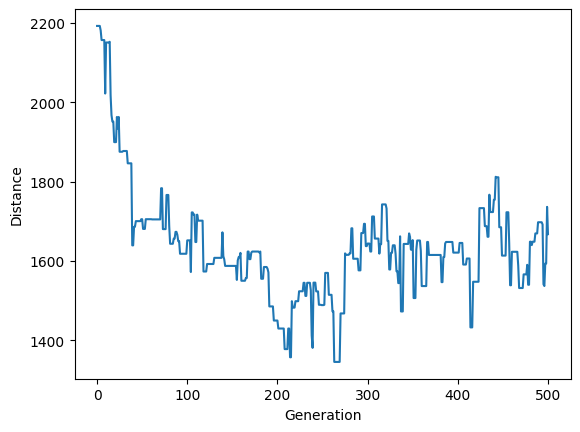

In [27]:
geneticAlgorithmPlot(population=pointsL, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

# Partie 3 : SMA collaboratif/non collaboratif

L'objectif de cette partie est de comparer la performance d'algorithmes génétiques non collaboratifs contre les algorithmes génétiques collaboratifs. Pour ce faire, nous allons créer un système multi-agent composé uniquement d'agents ayant un comportement optimisateur basé sur l'algorithme génétique que nous avons développé précédemment pour résoudre le PVC. Un agent mesa aura un attribut collaboratif égal à True s'il est collaboratif et False s'il ne l'est pas. Il aura également un attribut best égal à la distance minimale atteinte.

20. Créez un modèle mesa construit avec :
* la liste des points à visiter : listeP
* le nombre total d'agents du système : N (N/2 agents collaboratifs + N/2 agents non collaboratifs)
* la taille de la population : popSize
* le nombre d'élites à récupérer pour la prochaine génération : eliteSize
* le taux de mutation : mutationRate

In [28]:
pip install mesa==2.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.5/264.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 21.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Ajoutez au modèle un DataCollector permettant de collecter la distance minimlale atteinte par chaque agent optimisateur.

21. Créez maintenant un agent mesa ayant un comportement optimisateur basé sur l'algorithme génétique que nous avons développé précédemment pour résoudre le PVC. Conseil : Commencez par une version du SMA contenant uniquement des agents non collaboratifs.

Un agent est construit avec :
* pop : sa population initiale créée avec la fonction développée précédemment __**initialPopulation**__
* best : la meilleure distance atteinte calculée avec 1 / rankIts(self.pop)[0][1]
* collaboratif : True si l'agent est collaboratif et False s'il ne l'est pas

Plusieurs sciénarios/protocoles sont possibles.
Nous choisissons le scénario suivant :
Si l'agent n'est pas collaboratif, il va juste passer à la génération suivante à l'instant t+1 et mettre à jour son attribut best. S'il est collaboratif, il va en plus contacter tous les autres agents du système à la recherche d'une meilleure performance que lui. S'il trouve, il remplace son meilleur élément (chromosome) avec le chromosome qu'il a trouvé et qui donne une meilleure performance que lui.

22. Créez le programme principal permettant de résoudre le PVC avec un SMA collaboratif/non collaboratif en compatent les 2 modes (sur 500 générations). La comparaison doit se faire graphiquement. Il faut donc afficher l'évolution de la distance en fonction du temps pour chaque agent.

Le résultat du DataCollector (dataframe) __** agent_state = model.datacollector.get_agent_vars_dataframe() **__ devait ressembler  à :

![Capture d’écran 2024-03-08 à 18.08.28.png](attachment:313686c5-f7f0-4beb-8482-0cd44beb4f14.png)

Pour faciliter la génération du graphique, n'hésitez pas de transformer les lignes AgentID en colonnes en appliquant la fonction unstack() sur la dateframe agent_state :

__** res=agent_state.unstack() **__


Le résultat ressemblera à :

![Capture d’écran 2024-03-08 à 18.07.12.png](attachment:a4aa9347-0bc5-4dc8-b13a-ce9394d26caa.png)

Ce qui permettra un affichage du graphique comme suit (les agents 0, 1 et 2 ne sont pas collaboratifs et les autres le sont):

![Capture d’écran 2024-03-08 à 18.06.14.png](attachment:e15e79ae-b2e9-4d7f-9b1f-9dace426de8f.png)

**<span style="color:red">
SOLUTION
</span>**

# A vous de jouer !

Proposez maintenant une (ou plusieurs) variante(s) permettant d'améliorer la performance du SMA. Vous pouvez par exemple (et/ou):
* modifier le protocole de collaboration,
* changer le(s) paramètres(s) : taux de mutation, taille de la population, nombre de générations
* changer d'opérateur de mutation, de croisemeetnt
* Créer la population initiale avec une heuristique,, etVous pouvez également étudier la performance de votre solution en variant le nombre de pointstc....


**<span style="color:red">
SOLUTION
</span>**

**ALGO TABOU**

In [29]:
class TabuAgent(Agent):
    def __init__(self, unique_id, model, max_tabu_size=10, collaboratif=True):
        super().__init__(unique_id, model)
        self.pop = [random.sample(self.model.population, len(self.model.population))]
        self.best = self.calculate_distance(self.pop[0])
        self.tabu_list = []
        self.max_tabu_size = max_tabu_size
        self.collaboratif = collaboratif
        self.no_improvement_count = 0  # Compteur pour l’arrêt anticipé
        self.max_no_improvement = 5   # Seuil pour arrêter si pas d’amélioration

    def calculate_distance(self, solution):
        distance = 0
        for k in range(len(solution) - 1):
            distance += solution[k].dist(solution[k + 1])
        distance += solution[-1].dist(solution[0])
        return distance

    def get_neighbors(self, solution):
        neighbors = []
        # Limiter le nombre de voisins à 10% des permutations possibles pour optimiser
        n = len(solution)
        sample_size = min(n * (n - 1) // 2, max(10, n))  # Minimum 10 voisins ou 10% des permutations
        indices = random.sample([(i, j) for i in range(n) for j in range(i + 1, n)], sample_size)
        for i, j in indices:
            neighbor = copy.deepcopy(solution)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbors.append(neighbor)
        return neighbors

    def contact(self):
        min_distance = self.best
        best_agent = None
        for a in self.model.schedule.agents:
            if a.best < min_distance:  # Recherche de la meilleure solution globale
                min_distance = a.best
                best_agent = a

        # Recevoir une meilleure solution
        if best_agent and min_distance < self.best:
            best_idx = 0
            for i, indiv in enumerate(best_agent.pop):
                if Fitness(indiv).itFitness() > Fitness(best_agent.pop[best_idx]).itFitness():
                    best_idx = i
            self.pop[0] = best_agent.pop[best_idx]
            self.best = self.calculate_distance(self.pop[0])
            self.tabu_list.clear()  # Réinitialiser la liste tabou si une meilleure solution est trouvée
            self.no_improvement_count = 0

    def step(self):
        current_solution = self.pop[0]
        neighbors = self.get_neighbors(current_solution)
        best_neighbor = None
        best_neighbor_distance = float('inf')

        for neighbor in neighbors:
            neighbor_distance = self.calculate_distance(neighbor)
            if neighbor not in self.tabu_list and neighbor_distance < best_neighbor_distance:
                best_neighbor = neighbor
                best_neighbor_distance = neighbor_distance

        if best_neighbor and best_neighbor_distance < self.best:
            self.pop[0] = best_neighbor
            self.best = best_neighbor_distance
            self.tabu_list.append(best_neighbor)
            if len(self.tabu_list) > self.max_tabu_size:
                self.tabu_list.pop(0)
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1

        # Arrêt anticipé si aucune amélioration pendant trop longtemps
        if self.no_improvement_count < self.max_no_improvement and self.collaboratif:
            self.contact()

NameError: name 'Agent' is not defined

**COLLABORATION**

In [ ]:
!pip install mesa==3.1.0

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation  # Pour votre version actuelle
from mesa.datacollection import DataCollector
import random
import copy
import operator
import matplotlib.pyplot as plt

class OptGenAgent(Agent):

    def __init__(self, unique_id, model, collaboratif=False):
            super().__init__(unique_id, model)  
            self.pop = initialPopulation(self.model.popSize, self.model.population) 
            self.best = 1 / rankIts(self.pop)[0][1]  
            self.collaboratif = collaboratif

    def contact(self):
        min_best = self.best
        best_agent = None
        for a in self.model.schedule.agents: 
            if a.best < min_best:
                min_best = a.best
                best_agent = a

        if best_agent and min_best < self.best:
            mon_meilleure_fitness = 0
            for i in range(len(self.pop)):
                if Fitness(self.pop[i]).itFitness() > mon_meilleure_fitness:
                    mon_meilleure_fitness = Fitness(self.pop[i]).itFitness()
                    mon_meilleur_gene = i

            son_meilleure_fitness = 0
            for i in range(len(best_agent.pop)):
                if Fitness(best_agent.pop[i]).itFitness() > son_meilleure_fitness:
                    son_meilleure_fitness = Fitness(best_agent.pop[i]).itFitness()
                    son_meilleur_gene = i

            self.pop[mon_meilleur_gene] = best_agent.pop[son_meilleur_gene]
            self.best = 1 / rankIts(self.pop)[0][1]

    def step(self):
        self.pop = nextGeneration(self.pop, self.model.eliteSize, self.model.mutationRate)
        self.best = 1 / rankIts(self.pop)[0][1]
        if self.collaboratif:
            self.contact()

class TabuAgent(Agent):
    def __init__(self, unique_id, model, max_tabu_size=10, collaboratif=True):
        super().__init__(unique_id, model)  # Correctly call super()
        self.pop = [random.sample(model.population, len(model.population))]
        self.best = self.calculate_distance(self.pop[0])
        self.tabu_list = []
        self.max_tabu_size = max_tabu_size
        self.collaboratif = collaboratif
        self.no_improvement_count = 0  
        self.max_no_improvement = 5

    def calculate_distance(self, solution):
        distance = 0
        for k in range(len(solution) - 1):
            distance += solution[k].dist(solution[k + 1])
        distance += solution[-1].dist(solution[0])
        return distance

    def get_neighbors(self, solution):
        neighbors = []
        n = len(solution)
        sample_size = min(n * (n - 1) // 2, max(10, n))
        indices = random.sample([(i, j) for i in range(n) for j in range(i + 1, n)], sample_size)
        for i, j in indices:
            neighbor = copy.deepcopy(solution)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbors.append(neighbor)
        return neighbors

    def contact(self):
        min_best = self.best
        best_agent = None
        for a in self.model.schedule.agents:
            if a.best < min_best:
                min_best = a.best
                best_agent = a

        if best_agent and min_best < self.best:
            best_idx = 0
            for i, indiv in enumerate(best_agent.pop):
                if Fitness(indiv).itFitness() > Fitness(best_agent.pop[best_idx]).itFitness():
                    best_idx = i
            self.pop[0] = best_agent.pop[best_idx]
            self.best = self.calculate_distance(self.pop[0])
            self.tabu_list.clear()

    def step(self):
        current_solution = self.pop[0]
        neighbors = self.get_neighbors(current_solution)
        best_neighbor = None
        best_neighbor_distance = float('inf')

        for neighbor in neighbors:
            neighbor_distance = self.calculate_distance(neighbor)
            if neighbor not in self.tabu_list and neighbor_distance < best_neighbor_distance:
                best_neighbor = neighbor
                best_neighbor_distance = neighbor_distance

        if best_neighbor and best_neighbor_distance < self.best:
            self.pop[0] = best_neighbor
            self.best = best_neighbor_distance
            self.tabu_list.append(best_neighbor)
            if len(self.tabu_list) > self.max_tabu_size:
                self.tabu_list.pop(0)

        if self.collaboratif:
            self.contact()

class OptimisationCollaborativeModel(Model):
    def __init__(self, population, N_gen=5, N_tabu=1, popSize=100, eliteSize=20, mutationRate=0.01):
        super().__init__()
        self.population = population
        self.popSize = popSize
        self.eliteSize = eliteSize
        self.mutationRate = mutationRate
        self.schedule = RandomActivation(self)

        # Ajouter les agents génétiques (tous collaboratifs)
        for i in range(N_gen):
            a = OptGenAgent(i, self, True) 
            self.schedule.add(a)

        # Ajouter les agents tabou (collaboratifs par défaut)
        for i in range(N_tabu):
            a = TabuAgent(N_gen + i, self) 
            self.schedule.add(a)

        self.datacollector = DataCollector(
            agent_reporters={"Best": lambda a: a.best}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()  


generations = 100
cityList = [Point(x=int(random.random() * 200), y=int(random.random() * 200)) for _ in range(25)]

model_collab = OptimisationCollaborativeModel(cityList, N_gen=5, N_tabu=1)
for i in range(generations):
    print(f"Génération {i+1} (Collaboration)")
    model_collab.step()

agent_state_collab = model_collab.datacollector.get_agent_vars_dataframe()
res_collab = agent_state_collab.unstack()
print("Résultats avec collaboration :")
print(res_collab)
res_collab.plot(title="Collaboration AG + Tabou")
plt.show()
print("Meilleure valeur trouvée (Collaboration) : ", res_collab.min().min())

# Simulation sans collaboration (seulement AG)
model_no_collab = OptimisationCollaborativeModel(cityList, N_gen=6, N_tabu=0)  # 6 AG, pas de Tabou
for i in range(generations):
    print(f"Génération {i+1} (Sans collaboration)")
    model_no_collab.step()

agent_state_no_collab = model_no_collab.datacollector.get_agent_vars_dataframe()
res_no_collab = agent_state_no_collab.unstack()
print("Résultats sans collaboration :")
print(res_no_collab)
res_no_collab.plot(title="Seulement AG")
plt.show()
print("Meilleure valeur trouvée (Sans collaboration) : ", res_no_collab.min().min())